In [1]:
import os
import numpy as np
from random import sample

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.preprocessing.image import load_img, img_to_array

#Add other imports that you might need
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D, BatchNormalization, Activation
from keras import backend as K, regularizers

import inf619utils

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
datasetDir = "./Dataset"
trainPairFile = datasetDir + "/train_pairs.txt"
valPairFile = datasetDir + "/val_pairs.txt"
testPairFile = datasetDir + "/test_pairs.txt"

input_shape = (112,112,3)

def preProcessPair(line):
    img1Path, img2Path, label = line.strip().split(" ")

    img1 = img_to_array(load_img(img1Path, target_size=input_shape))
    img1 = img1.astype('float32')
    img1 /= 255.0

    img2 = img_to_array(load_img(img2Path, target_size=input_shape))
    img2 = img2.astype('float32')
    img2 /= 255.0
    
    label = int(label)
    
    return img1, img2, label
    
#Read our dataset in batches
def loadDatasetInBatches(pairFile = trainPairFile, batch_size=32, shouldAugmentData=False):

    ######### If you want to run with Data Augmentation, just uncomment here and some lines bellow
    ##### you can add more transformations (see https://keras.io/preprocessing/image/)
    #if shouldAugmentData == True:
        #dataAugmentator = ImageDataGenerator(...)
    

    with open(pairFile, "r") as f:
        lines = f.readlines()
    
    while True:
        shuffledLines = sample(lines, len(lines)) #shuffle images in each epoch
        
        leftBatch, rightBatch, labelList = [], [], []
        nInBatch = 0
        
        #loop of one epoch
        for idx in list(range(len(shuffledLines))):
                        img1, img2, label = preProcessPair(shuffledLines[idx])
    
                        ### We apply a random transformation and add this image (instead of the original)
                        ### to the batch...
                        #if shouldAugmentData == True:
                            #img1 = dataAugmentator.random_transform(img1)
                            #img2 = dataAugmentator.random_transform(img2)
    
                        leftBatch.append(img1)
                        rightBatch.append(img2)
                        labelList.append(label)
                        nInBatch += 1
                        
                        #if we already have one batch, yields it
                        if nInBatch >= batch_size:
                            yield [np.array(leftBatch),np.array(rightBatch)], np.array(labelList)
                            leftBatch, rightBatch, labelList = [], [], []
                            nInBatch = 0

        #yield the remaining of the batch
        if nInBatch > 0:
            yield [np.array(leftBatch),np.array(rightBatch)], np.array(labelList)

def getDatasetSize(pairFile):
    with open(pairFile, "r") as f:
        lines = f.readlines()
    return len(lines)

               
def plotPair(img1, img2):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(121)
    ax.imshow(np.uint8(img1.reshape(input_shape)*255.0), interpolation='nearest')
    
    ax = fig.add_subplot(122)
    ax.imshow(np.uint8(img2.reshape(input_shape)*255.0), interpolation='nearest')
    plt.show()
    
trainSetSize = getDatasetSize(trainPairFile)
valSetSize = getDatasetSize(valPairFile)
testSetSize = getDatasetSize(testPairFile)

print("# pairs in Train set: ", trainSetSize)
print("# pairs in Val set: ", valSetSize)
print("# pairs in Test set: ", testSetSize)

# pairs in Train set:  308524
# pairs in Val set:  19098
# pairs in Test set:  52226


Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


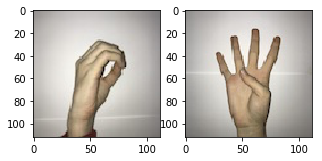

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


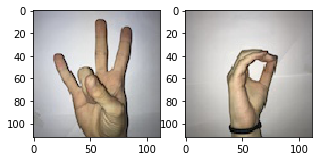

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 1


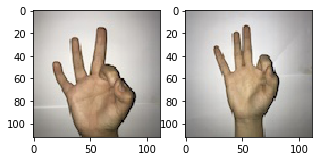

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


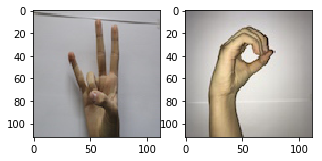

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


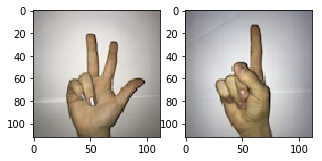

In [3]:
for batch, labels in loadDatasetInBatches(trainPairFile, batch_size=5):
    idx = 0
    leftBatch, rightBatch = batch
    for idx in list(range(leftBatch.shape[0])):
        print("Image1 size: ", leftBatch[idx].shape, "\t", "Image2 size: ", rightBatch[idx].shape,"\t Label:", labels[idx])
        plotPair(leftBatch[idx], rightBatch[idx])
    break

In [4]:
#Compute classification accuracy with a fixed threshold on distances.
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

#Compute the euclidean distance of two arrays
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

#Defina sua arquitetura
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Convolution2D(32, (3,3))(input)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Convolution2D(64, (3,3))(x)
    x = Activation('relu')(x)
    x = Convolution2D(128, (3,3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dropout(0.20)(x)
    x = Dense(256, activation='relu')(x) # <-------- not the number of classes
    return Model(input, x)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
encoding_a = base_network(input_a)
encoding_b = base_network(input_b)

# Calculate the euclidean distance of the two arrays
distance = Lambda(euclidean_distance)([encoding_a, encoding_b])

# Define final model
model = Model([input_a, input_b], distance)

In [5]:
#Compile o modelo / Defina a loss 
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Compilation
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy]) #<-- different accuracy metric


In [6]:
#Definir tamanho do batch e número de épocas
batch_size = 32
epochs = 3

#Criação dos generators
# IMPORTANTE ---> Se for utilizar data augmentation, passe a flag shouldAugmentData como True no treinamento
trainGenerator = loadDatasetInBatches(trainPairFile, batch_size = batch_size) #shouldAugmentData = True
valGenerator = loadDatasetInBatches(valPairFile, batch_size = batch_size) #shouldAugmentData = False

#Fit nos dados
model.fit_generator(trainGenerator, 
                    steps_per_epoch= int(trainSetSize / batch_size)/5, 
                    epochs = epochs,
                    validation_data = valGenerator,  
                    validation_steps = int(valSetSize / batch_size)/5)

Epoch 1/3
1929/1928 [==============================] - 1270s 658ms/step - loss: 0.0440 - accuracy: 0.9640 - val_loss: 0.0384 - val_accuracy: 0.9656
Epoch 2/3
1929/1928 [==============================] - 1379s 715ms/step - loss: 0.0081 - accuracy: 0.9997 - val_loss: 0.0399 - val_accuracy: 0.9635
Epoch 3/3
1929/1928 [==============================] - 2161s 1s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 0.9784


# Teste [0.15 pts]
O teste será feito da mesma forma, utilizando `loadDatasetInBatches` para o conjunto de teste. 

In [7]:
#Criação do generator p/ o conjunto de teste
testGenerator = loadDatasetInBatches(testPairFile, batch_size=batch_size)

#Teste
metrics = model.evaluate_generator(testGenerator, 
                                   steps=int(testSetSize/batch_size), 
                                   verbose=1)

print("Test Loss ---> ", metrics[0])
print("Test Accuracy ---> ", metrics[1])    #Test is balanced, so Acc is normalized

1632/1632 [==============================] - 756s 463ms/step
Test Loss --->  0.03457227178396173
Test Accuracy --->  0.9750114889705882


In [8]:
model.save('model_siamese.h5')

**Conclusões  [0.25 pts]
Escreva um parágrafo com as conclusões que você tirou na tarefa. Comente as dificuldades encontradas, as tentativas feitas, como foi o seu treinamento, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?**

Esse projeto foi muito interessante para o apprendizado de modelos siameses. Foi um grande desafio, pois as redes atingem Overfitting muito rapidamente, devido ao conjunto de dados de treinamento não muito grande.
Durante o desenvolvimento, tentamos algumas técnicas, cujos resultados serão explicitados abaixo:
- Batch Normalization: Causou uma redução para cerca de 50% na acurácia
- Regularização dos dados: Causou uma leve melhora no overfitting (mais épocas), mas causou tabém uma leve diminuição na acurácia (queda de aproximadamente 10%).
Optamos por um modelo parecido com o do exemplo de aula, mas trocamos alguns parâmetros. Adicionamos uma camada Convolucional a mais, na tentativa de aumentar o número de filtros e diminuir o tamanho (w x h) das imagens. Conseguimos uma melhora nos resultados, mas o overfitting estava presente.
Como opção, diminuímos o número de steps_per_batch, para 20% dos dados, e rodamos por 5 épocas, para que todos os dados fossem utilizados no treinamento. Como é possível ver, na 5a época ainda há um leve overfitting, percebido pela diminuição da acurácia de validação e leve aumento da loss. 

Numa simulação de 4 épocas, obtivemos os seguintes valores:

Epoch 1/4
1534/1533 [==============================] - 1629s 1s/step - loss: 0.0302 - accuracy: 0.9796 - val_loss: 0.1447 - val_accuracy: 0.8109
Epoch 2/4
1534/1533 [==============================] - 1241s 809ms/step - loss: 0.0083 - accuracy: 0.9996 - val_loss: 0.1467 - val_accuracy: 0.8116
Epoch 3/4
1534/1533 [==============================] - 699s 455ms/step - loss: 0.0067 - accuracy: 0.9999 - val_loss: 0.1381 - val_accuracy: 0.8280
Epoch 4/4
1534/1533 [==============================] - 685s 447ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1368 - val_accuracy: 0.8276

Que ainda demonstram leve diminuição de acurácia e aumento de loss na última época, mas temos o contra-ponto de não estarmos utilizando todos os dados do treinamento, e isso pode ser um risco. Então optamos pelo modelo aqui presente, que também resultou na melhor acurácia de teste, com aproximadamente 90%. No modelo com 4 épocas, tivemos apenas 88%.

Com mais tempo, poderíamos ainda ter experimentado modelos com DataAugmentation e também outras variações e combinações de regularization e batchs_per_step. Poderíamos também testar outras funções de cálculo da loss e de distância, para verificar como os resultados seriam impactados.